## 1D harmonic oscillator physics-informed neural network (PINN) with TensorFlow
Accompined tensorflow code of Ben Moseley's blog post ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/)\
Please read the post for more details.

## Problem overview

The example problem we solve here is the 1D damped harmonic oscillator  
$$
m\frac{d^2x}{dt^2} + \mu \frac{dx}{dt} + kx = 0,
$$
with initial condition
$$
x(0) = 1,\quad \frac{dx}{dt} = 0
$$
We will focus on solving the problem for the under-damped state, i.e. when
$$
\delta < \omega_{0},\quad with\quad \delta = \frac{\mu}{2m},\quad  \omega_{0} = \sqrt\frac{k}{m}
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t} (2Acos(\phi + \omega t)),\quad with\quad \omega = \sqrt{\omega^{2}_{0} - \delta^{2}}
$$
\
This problem was inspired by the following blog post:[ https://beltoforion.de/en/harmonic_oscillator/.](https://beltoforion.de/en/harmonic_oscillator/)

## Workflow overview
First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.

## Environment set up
Here, unlike Ben Moseley, I am training the PINN using TensorFlow

In [1]:
from PIL import Image

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
def save_gif_PIL(outfile, files, fps = 5, loop = 0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp = outfile, format='GIF', append_images = imgs[1:], save_all = True, duration = int(1000/fps), loop = loop)

def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem.
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = np.cos(phi+w*x)
    sin = np.sin(phi+w*x)
    exp = np.exp(-d*x)
    y  = exp*2*A*cos
    return y

class FCN(tf.keras.Model):
  def __init__(self, n_input, n_output, n_hidden, n_layers):
    super(FCN, self).__init__()
    activation = tf.keras.activations.tanh

    self.fcn = models.Sequential([
        layers.Dense(n_hidden, activation = activation, input_shape = (n_input,))
    ])

    self.fch = models.Sequential()
    for _ in range(n_layers - 1):
      self.fch.add(models.Sequential([
          layers.Dense(n_hidden, activation = activation)
      ]))

    self.fce = layers.Dense(n_output)

  def call(self, x):
    x = self.fcn(x)
    x = self.fch(x)
    x = self.fce(x)
    return x

## Generate training data
First, we generate some training data from a small part of the true analytical solution.\
For this problem, we use $\delta = 2,\quad \omega_{0} = 20$, and try to learn the solution over the domain $x\in [0,1]$.

(500, 1) (500, 1)
(10, 1) (10, 1)


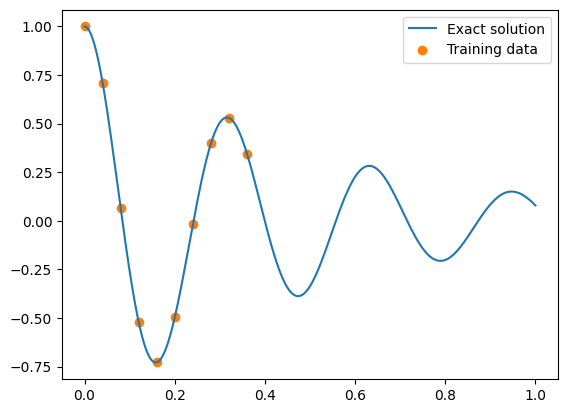

In [3]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = tf.linspace(0.0, 1.0, 500)
x = tf.reshape(x, (-1, 1))
y = oscillator(d, w0, x)
y = tf.reshape(y, (-1, 1))
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

## Normal neural network
Next, we train a standard neural network (fully connected network) to fit these training points.

We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


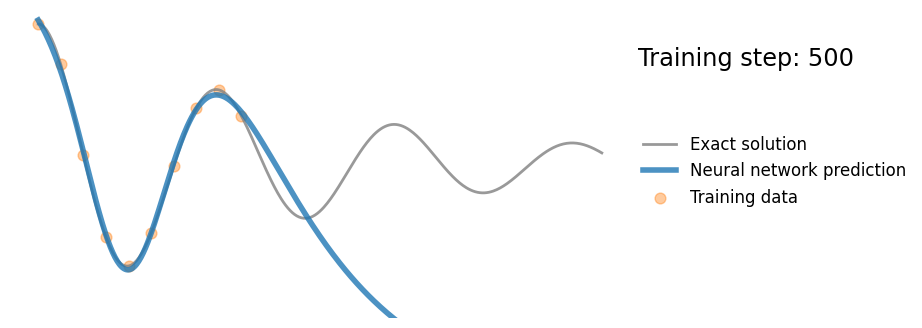

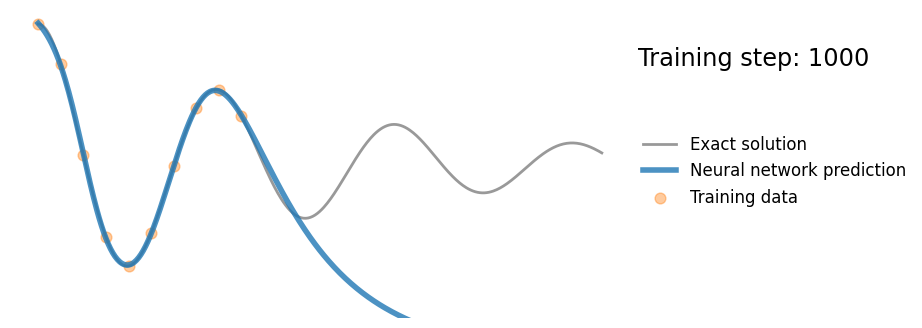

In [4]:
import os

os.makedirs("plots", exist_ok = True)

def plot_result(x, y, x_data, y_data, yh, xp = None):
    "Pretty plot training results"
    plt.figure(figsize = (8,4))
    plt.plot(x,y, color = "grey", linewidth = 2, alpha = 0.8, label = "Exact solution")
    plt.plot(x,yh, color = "tab:blue", linewidth = 4, alpha = 0.8, label = "Neural network prediction")
    plt.scatter(x_data, y_data, s = 60, color = "tab:orange", alpha = 0.4, label = 'Training data')
    if xp is not None:
        plt.scatter(xp, -0*tf.ones_like(xp), s = 60, color="tab:green", alpha = 0.4,
                    label = 'Physics loss training locations')
    l = plt.legend(loc = (1.01,0.34), frameon = False, fontsize = "large")
    plt.setp(l.get_texts(), color = "k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize = "xx-large",color = "k")
    plt.axis("off")

# Initialize an empty list to store file names
files = []

# train standard neural network to fit training data
tf.random.set_seed(123)

# Instantiate the model
model = FCN(1, 1, 32, 3)

# Define the optimizer in TensorFlow
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

# Training loop
for i in range(1000):
    with tf.GradientTape() as tape:
        # Forward pass
        yh = model(x_data, training = True)

        # Compute the mean squared error loss
        loss = tf.reduce_mean(tf.square(yh - y_data))

    # Backward pass
    gradients = tape.gradient(loss, model.trainable_variables)

    # Update the model's parameters
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # plot the result as training progresses
    if (i+1) % 10 == 0:

        with tf.GradientTape(persistent=True) as tape:
          tape.watch(x)
          yh = model(x)
          yh_detached = tf.stop_gradient(yh)

        plot_result(x, y, x_data, y_data, yh)

        file = "plots/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi = 100, facecolor = "white")
        files.append(file)

        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")

save_gif_PIL("nn.gif", files, fps=20, loop = 0)

## PINN
Finally, we add the underlying differential equation ("physics loss") to the loss function.

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

Here we evaluate the physics loss at 30 points uniformly spaced over the problem domain $([0,1])$
. We can calculate the derivatives of the network solution with respect to its input variable at these points using tensorflow's GradientTape features, and can then easily compute the residual of the differential equation using these quantities.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


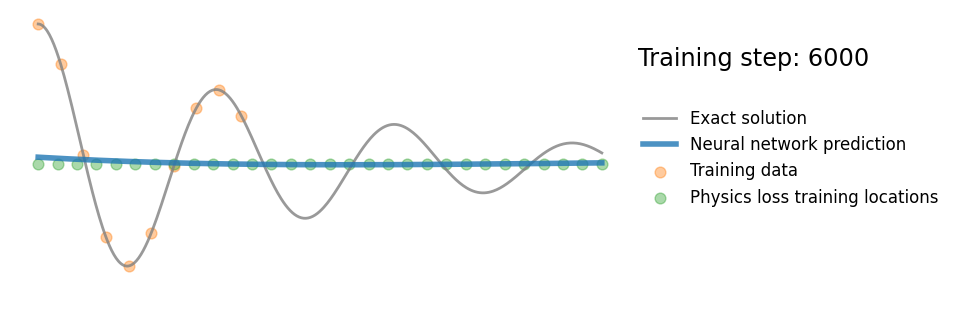

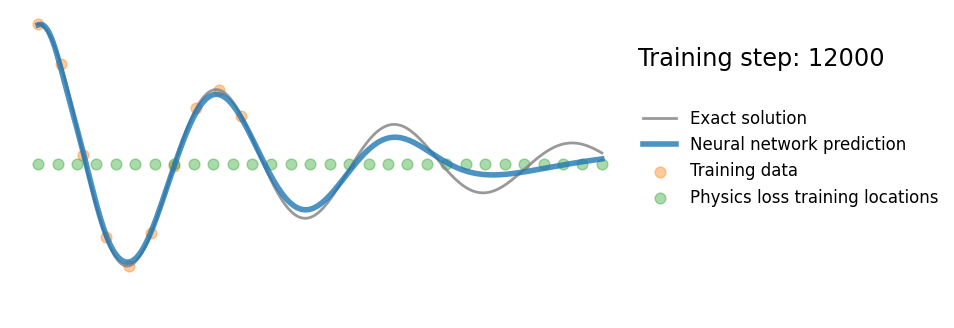

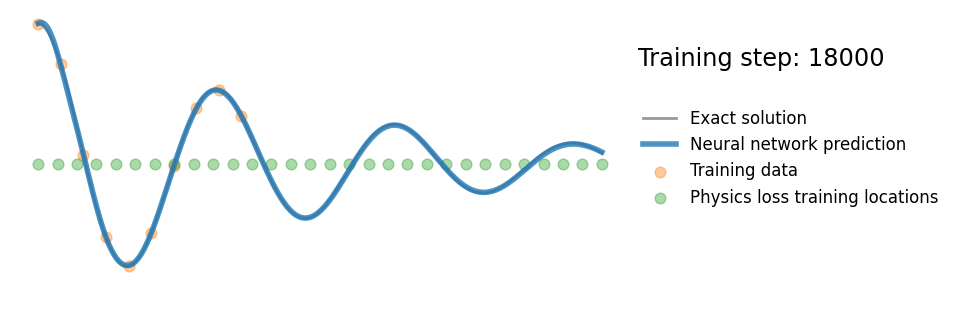

In [6]:
x_physics = tf.linspace(0.0, 1.0, 30)
x_physics = tf.reshape(x_physics, (-1, 1))
x_physics = tf.Variable(x_physics, trainable=True, dtype=tf.float32)  # make it trainable (requires_grad=True equivalent)

mu = 2 * d
k = w0 ** 2

tf.random.set_seed(123)

# Instantiate the model
model = FCN(1, 1, 32, 3)                  # Keeping the model same, we'll just change the loss function

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

files = []

for i in range(20000):
    # Since we're combining both loss1 and loss2, this computation should happen inside the same GradientTape context.
    with tf.GradientTape(persistent = True) as tape:

        # Compute the 'data loss'
        yh = model(x_data)
        loss1 = tf.reduce_mean(tf.square(yh - y_data))

        # Compute the 'physics loss'
        yhp = model(x_physics)
        dx = tape.gradient(yhp, x_physics)
        dx2 = tape.gradient(dx, x_physics)
        physics = dx2 + mu * dx + k * yhp
        loss2 = 1e-4 * tf.reduce_mean(tf.square(physics))

        # backpropagate joint loss
        loss = loss1 + loss2  # add two loss terms together

        # compute the gradients and update the model parameters
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # plot the result as training progresses
        if (i + 1) % 150 == 0:

            yh = model(x)
            xp = x_physics

            # Convert TensorFlow tensors to numpy arrays for plotting
            yh = yh.numpy()
            xp = xp.numpy()

            # Call your custom plotting function
            plot_result(x, y, x_data, y_data, yh, xp)

            file = "plots/pinn_%.8i.png" % (i + 1)
            plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
            files.append(file)

            if (i + 1) % 6000 == 0:
                plt.show()
            else:
                plt.close("all")

# Save the collected images as a GIF
save_gif_PIL("pinn.gif", files, fps=20, loop=0)